# 1. Импортирование библиотек и парсинг данных

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import re
import os
from glob import glob
from matplotlib.patches import Rectangle
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import shutil
import codecs
# Отключаем проверку
import warnings
warnings.filterwarnings("ignore")

In [3]:
list_bmp = [] # Массив путей к bmp
list_frame = [] # Массив путей к frame
def parsing_bmp(dir):
    list = os.listdir(dir)    
    for item in glob(dir+'\\'+'*.bmp'):
        list_bmp.append(item)
    for item in glob(dir+'\\'+'*.frame'):
        list_frame.append(item)
    for dir_for in list:
        if os.path.isdir(dir+'\\'+dir_for):
            parsing_bmp(dir+'\\'+dir_for)
parsing_bmp('.')
list_bmp[:10]

['.\\DATASET\\FRAMES\\frame0000.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0000.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0001.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0002.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0003.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0004.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0005.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0006.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0007.bmp',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0008.bmp']

In [4]:
list_frame[:10]

['.\\DATASET\\FRAMES\\frame0000.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0000.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0001.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0002.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0003.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0004.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0005.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0006.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0007.frame',
 '.\\DATASET\\FRAMES\\0\\1530\\frame0008.frame']

In [5]:
print(f'Файлов формата bmp {len(list_bmp)} и формата frame {len(list_frame)}')

Файлов формата bmp 7808 и формата frame 7808


# 2. Чтение изображения

In [6]:
images = []
for file in tqdm(list_bmp):
    try:
        image = cv2.imread(file, cv2.IMREAD_COLOR) 
        image = cv2.resize(image, dsize=(960, 600))
        images.append(image)
    except:
        pass
print(f'Прочиталось {len(images)} изображений')

100%|█████████████████████████████████████████████████████████████████████████████| 7808/7808 [00:50<00:00, 153.80it/s]

Прочиталось 7125 изображений


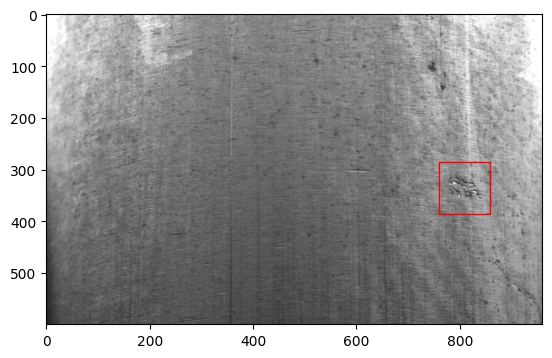

In [89]:
image = cv2.imread('.\\DATASET\\FRAMES\\0\\1538\\frame0006.bmp', cv2.IMREAD_COLOR) 
image = np.array(image)
image = image.astype('float32')
image = image / 255.0
plt.gca().add_patch (Rectangle((809-50,336-50),100,100,edgecolor='red', facecolor='none', lw= 1 ))
plt.imshow(image)

# 3. Чтение выборок

In [180]:
def dict_frames_maker(path, prefix, sampling, *, show=False):
    file = open(path, "r")
    with codecs.open(path, 'r', encoding='cp1251') as fdata:
        list_lines = fdata.readlines()
    # Создаём папки с выборкой
    if not os.path.exists('image'):
        os.mkdir('image')
    if not os.path.exists('label'):
        os.mkdir('label')
    if not os.path.exists('.\\image\\'+ sampling):
        os.mkdir('.\\image\\'+ sampling)
    if not os.path.exists('.\\label\\'+ sampling):
        os.mkdir('.\\label\\'+ sampling)
    key = 0 
    dict_frames = {}
    dict_value = [] # Список с данными об 

    for item in list_lines:
        item = item[:-2]
        if item.endswith('.frame'):
            dict_frames[key] = dict_value
            key = prefix+item
            key = key.replace(".frame", ".bmp")
            dict_value = []
        else:
            try:
                height, width, channels = cv2.imread(key).shape # Получаем размеры изображения
                items_coor = [int(i) for i in item.split(', ')] # массив детекции с X, Y, CLASS
                dict_value.append(' '.join([str(items_coor[2]), str(items_coor[0] / width), str(items_coor[1] / height),
                                   str(50 / width), str(50 / height)]))
            except:
                pass
    del dict_frames[0]
    for item in dict_frames.keys():
        try:
            shutil.copy(item, '.\\image\\'+sampling+'\\'+item[item.rfind('\\'):])
            with open('.\\label\\'+sampling+'\\'+item[item.rfind('\\'):].replace('.bmp', '.txt'), 'w') as f:
                for i in dict_frames[item]:
                    f.write(i+'\n') 
        except:
            pass
    if show:
        for key in dict_frames: print(key + ':', dict_frames[key])
    return dict_frames

In [181]:
%%time
path = ".\\DATASET\\metadata\set.cfg"
prefix = '.\\DATASET\\FRAMES\\'
train_json = dict_frames_maker(path, prefix, 'train')
train_json

CPU times: total: 20 s
Wall time: 49 s


{'.\\DATASET\\FRAMES\\0\\1538\\frame0006.bmp': ['3 0.8427083333333333 0.56 0.052083333333333336 0.08333333333333333',
  '0 0.6260416666666667 0.49833333333333335 0.052083333333333336 0.08333333333333333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0007.bmp': ['3 0.6947916666666667 0.53 0.052083333333333336 0.08333333333333333',
  '3 0.8447916666666667 0.8716666666666667 0.052083333333333336 0.08333333333333333',
  '0 0.4635416666666667 0.5 0.052083333333333336 0.08333333333333333',
  '0 0.35208333333333336 0.15666666666666668 0.052083333333333336 0.08333333333333333',
  '0 0.8989583333333333 0.45166666666666666 0.052083333333333336 0.08333333333333333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0009.bmp': ['3 0.6 0.5216666666666666 0.052083333333333336 0.08333333333333333',
  '3 0.7541666666666667 0.8483333333333334 0.052083333333333336 0.08333333333333333',
  '0 0.9 0.65 0.052083333333333336 0.08333333333333333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0011.bmp': ['3 0.4979166666666667 0.84 0.05208

In [182]:
%%time
path = ".\\DATASET\\metadata\\test_set.cfg"
prefix = '.\\DATASET\\FRAMES\\'
test_json = dict_frames_maker(path, prefix, 'test')
test_json

CPU times: total: 6.41 s
Wall time: 45 s


{'.\\DATASET\\FRAMES\\0\\1538\\frame0006.bmp': ['3 0.8427083333333333 0.56 0.052083333333333336 0.08333333333333333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0007.bmp': ['3 0.6947916666666667 0.53 0.052083333333333336 0.08333333333333333',
  '3 0.8447916666666667 0.8716666666666667 0.052083333333333336 0.08333333333333333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0009.bmp': ['3 0.6 0.5216666666666666 0.052083333333333336 0.08333333333333333',
  '3 0.7541666666666667 0.8483333333333334 0.052083333333333336 0.08333333333333333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0011.bmp': ['3 0.4979166666666667 0.84 0.052083333333333336 0.08333333333333333',
  '3 0.33958333333333335 0.5366666666666666 0.052083333333333336 0.08333333333333333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0012.bmp': ['3 0.290625 0.5433333333333333 0.052083333333333336 0.08333333333333333',
  '3 0.45 0.8383333333333334 0.052083333333333336 0.08333333333333333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0013.bmp': ['3 0.2520833333333333 0

In [175]:
count_train = len(os.listdir('.\\train\\image\\'))
count_test = len(os.listdir('.\\test\\image\\'))
print(f"Изображений в тренировочной выборке: {count_train}\nИзображений в тестовой выборке {count_test}")
del count_test, count_train

Изображений в тренировочной выборке: 3782
Изображений в тестовой выборке 2749


In [189]:
json_yalm = {
    "path": ".",
    "train": "image/train",
    "val": "image/train",
    "test": "image/test"
}
def dict_classes_maker(path):
    with codecs.open(path, 'r', encoding='cp1251') as fdata:
        list_lines=fdata.readlines()

        my_dict={}

        for line in list_lines:
            items = line.split(', ')
            my_dict[items[0].split()[1]]=items[-1][:-2]
        
        return my_dict

ded = dict_classes_maker('./DATASET/metadata/classes.cfg')

json_yalm['class'] = ded
json_yalm

{'path': '.',
 'train': 'image/train',
 'val': 'image/train',
 'test': 'image/test',
 'class': {'0': 'не дефект',
  '1': 'потертость',
  '2': 'черная точка',
  '3': 'плена',
  '4': 'маркер',
  '5': 'грязь',
  '6': 'накол',
  '7': 'н.д. накол',
  '8': 'микровыступ',
  '9': 'н.д. микровыступ',
  '10': 'вмятина',
  '11': 'мех.повреждение',
  '12': 'риска',
  '13': 'царапина с волчком'}}

In [195]:
import yaml

# Преобразование данных в формат YAML
yaml_data = yaml.dump(json_yalm)

# Запись данных в файл в формате YAML
with open('yaml_format.yaml', 'w', e) as file:
    file.write(yaml_data)

# 3. Модель

In [192]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")

In [196]:
results = model.train(data='yaml_format.yaml', epochs=100, imgsz=640)

Ultralytics YOLOv8.0.227 🚀 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=yaml_format.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=Non

RuntimeError: Dataset 'yaml_format.yaml' error  yaml_format.yaml key missing .
 either 'names' or 'nc' are required in all data YAMLs.